In [2]:
import json
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
import os

In [3]:
p = '../screenCaptureData'
data = {}
for i in os.listdir(p):
    with open(p + f'/{i}') as f:
        d = json.loads(f.read())
    data[os.path.splitext(i)[0]] = d
    

In [4]:
def playerplot(name, eventid):
    for stockid in data[eventid]:
        stock = data[eventid][stockid]
        check = stock[list(stock.keys())[0]]['stock']['name']
        if check == name:
            break
    if check != name:
        raise Exception('Player not found')
    pddata = pd.DataFrame.from_dict(stock, orient = 'index').reset_index()
    # return pddata
    pddata['fpproj'] = [i if np.isnan(j) else j for i,j in pddata[['fantasy_points_projected', 'fantasy_points_projected_live']].values]
    pddata['fpact'] = [i if not np.isnan(i) else 0 for i in pddata.fantasy_points_scored]
    pddata['price'] = list(pd.Series([float(i) if pd.isnull(j) else float(j) for i,j in pddata[['estimated_price', 'ask_price']].values]).fillna(0))
    # pddata['price'] = pddata.estimated_price
    pddata['time'] = pd.to_datetime(pddata['time']) - pd.Timedelta(hours = 5)

    plotdata = pddata.set_index('time')[['fpproj', 'fpact', 'price']].reset_index()
    plotdata = plotdata.melt('time', var_name = 'cols', value_name = 'vals')
    plotdata['vals'] = [float(i) for i in plotdata.vals]

    fig = plt.figure(figsize = (12, 6))
    ax = fig.gca()
    ax.set_title(name)
    g = sns.lineplot(x = 'time', y = 'vals', hue = 'cols', data = plotdata, ax = ax)
    return g


C:\Users\eamay\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


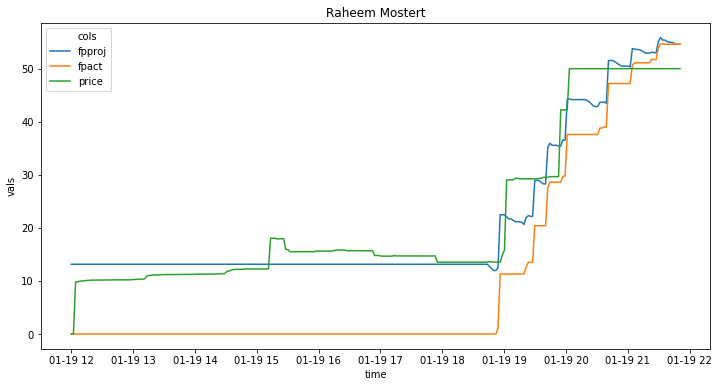

In [5]:
playerplot('Raheem Mostert', "evt_c1e04a4f3003dce1549aafec89224dc1")

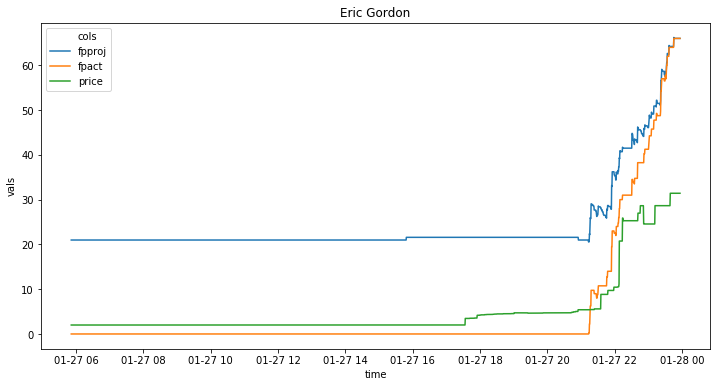

In [6]:
e = playerplot('Eric Gordon', 'evt_11e77bcdb4362e13')

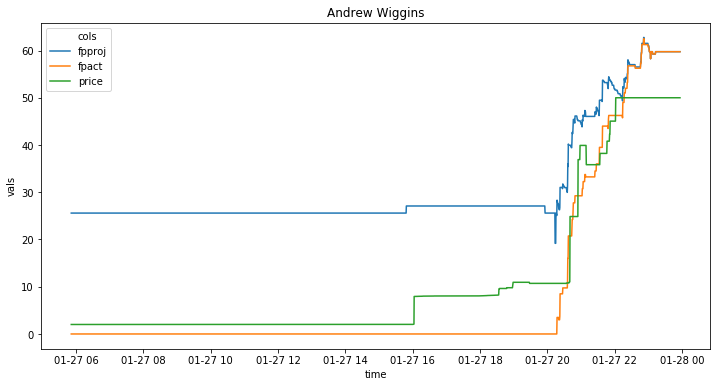

In [7]:
playerplot('Andrew Wiggins', 'evt_11e77bcdb4362e13')

In [43]:
def createDataFrame(event_id):
    df = pd.DataFrame.from_dict({(i, j): data[event_id][i][j] for i in data[event_id].keys() for j in data[event_id][i].keys()}, orient = 'index').reset_index()
    df['name'] = [df[i:i+1]['stock'].to_dict()[i]['name'] for i in range(len(df))]
    df['position'] = [df[i:i+1]['stock'].to_dict()[i]['details']['position'] for i in range(len(df))]
    df['fpproj'] = [i if np.isnan(j) else j for i,j in df[['fantasy_points_projected', 'fantasy_points_projected_live']].values]
    df['fpact'] = [i if not np.isnan(i) else 0 for i in df.fantasy_points_scored]
    df['price'] = list(pd.Series([float(i) if pd.isnull(j) else float(j) for i,j in df[['estimated_price', 'ask_price']].values]).fillna(0))
    # pddata['price'] = pddata.estimated_price
    df['time'] = pd.to_datetime(df['time']) - pd.Timedelta(hours = 5)
    df['round_time'] = [df['time'][i] - pd.Timedelta(minutes=df['time'][i].minute%1, seconds=df['time'][i].second, microseconds = df['time'][i].microsecond) for i in range(len(df))]
    return df

In [9]:
df = createDataFrame('evt_11e77bcdb4362e13')

In [10]:
def multi(df, name):
    if type(name) == str:

        d = df[df.name == name]

        fig = plt.figure()
        ax = fig.gca()
        b = [
            ax.plot(d.round_time, pd.to_numeric(d.bid_price), color = 'red')[0],
            ax.plot(d.round_time, pd.to_numeric(d.ask_price), color = 'green')[0],
            ax.plot(d.round_time, pd.to_numeric(d.fantasy_points_projected_live), color= 'blue')[0]
        ]
        ax.legend(a, ['bid price', 'ask price', 'fantasy projected live'])
        ax.set_title(name)

    else:
        if len(name) <= 4:
            fig, ax = plt.subplots(nrows = 1, ncols = len(name), sharey = True)
            fig.set_figwidth(6*len(name))
            fig.set_figheight(6)
        else:
            fig, ax = plt.subplots(nrows = int(np.ceil(len(name)/4)), ncols = 4, sharex = True, sharey = True)
            fig.set_figwidth(24)
            fig.set_figheight(6*int(np.ceil(len(name)/4)))
        
        for e, n in enumerate(name):
            try:
                a = ax.flatten()[e]
            except:
                break

            d = df[df.name == n]

            b = [
                a.plot(d.round_time, pd.to_numeric(d.bid_price), color = 'red')[0],
                a.plot(d.round_time, pd.to_numeric(d.ask_price), color = 'green')[0],
                a.plot(d.round_time, pd.to_numeric(d.fantasy_points_projected_live), color= 'blue')[0]
            ]
            if e == 0:
                a.legend(b, ['bid price', 'ask price', 'fantasy projected live'])
            a.set_title(n)




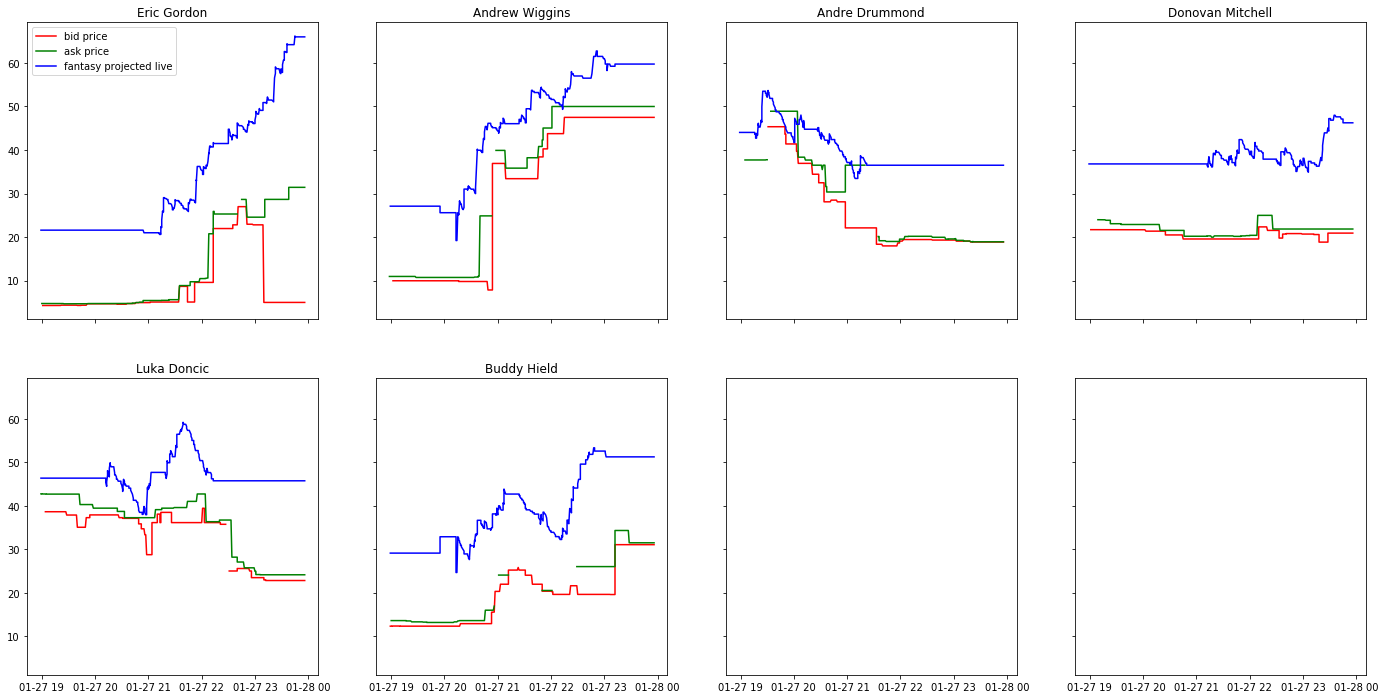

In [11]:
name = ['Eric Gordon', 'Andrew Wiggins', 'Andre Drummond', 'Donovan Mitchell', 'Luka Doncic', 'Buddy Hield']
multi(df, name)

In [12]:
df = createDataFrame("evt_e369b5a56fadc620")

In [13]:
def over_under_by_rank(df):
    rank_10, rank_20, rank_30, rank_40, rank_50 = [], [], [], [], []
    for e, n in enumerate(df[df.round_time == np.min(df.round_time)].sort_values(by = 'fpproj').name):
        if e < 10:
            rank_10.append(n)
        if 10 <= e < 20:
            rank_20.append(n)
        if 20 <= e < 30:
            rank_30.append(n)
        if 30 <= e < 40:
            rank_40.append(n)
        if 40 <= e < 50:
            rank_50.append(n)

    ranks = [rank_10, rank_20, rank_30, rank_40, rank_50]
    
    index, max_num = 0, 0
    for i in df.groupby('round_time').count().level_0.unique():
        guess = len([j for j in df.groupby('round_time').count().level_0 if j == i])
        if guess > max_num:
            max_num = guess
            index = i
            
    round_times = df.groupby('round_time').count().reset_index()[df.groupby('round_time').count().reset_index().level_0 == index].round_time
    live_df = df.loc[df.round_time.isin(round_times)].loc[df.round_time >= np.min(df.loc[df.fpact != 0].round_time)]
    live_df.loc['fpdiff'] = live_df.fpact - live_df.fpproj
    
    fig, axis = plt.subplots(nrows = 1, ncols = 5, sharey = True, figsize = (25,12))
    for e, r in enumerate(ranks):
        ax = axis[e]
        live_df.loc[live_df.name.isin(r)].groupby('round_time').mean().reset_index().plot(x = 'round_time', y = 'fantasy_points_projected_live', ax = ax)
        live_df.loc[live_df.name.isin(r)].groupby('round_time').mean().reset_index().plot(x = 'round_time', y = 'fantasy_points_projected', ax = ax)
        if e != 0:
            ax.legend('')
    

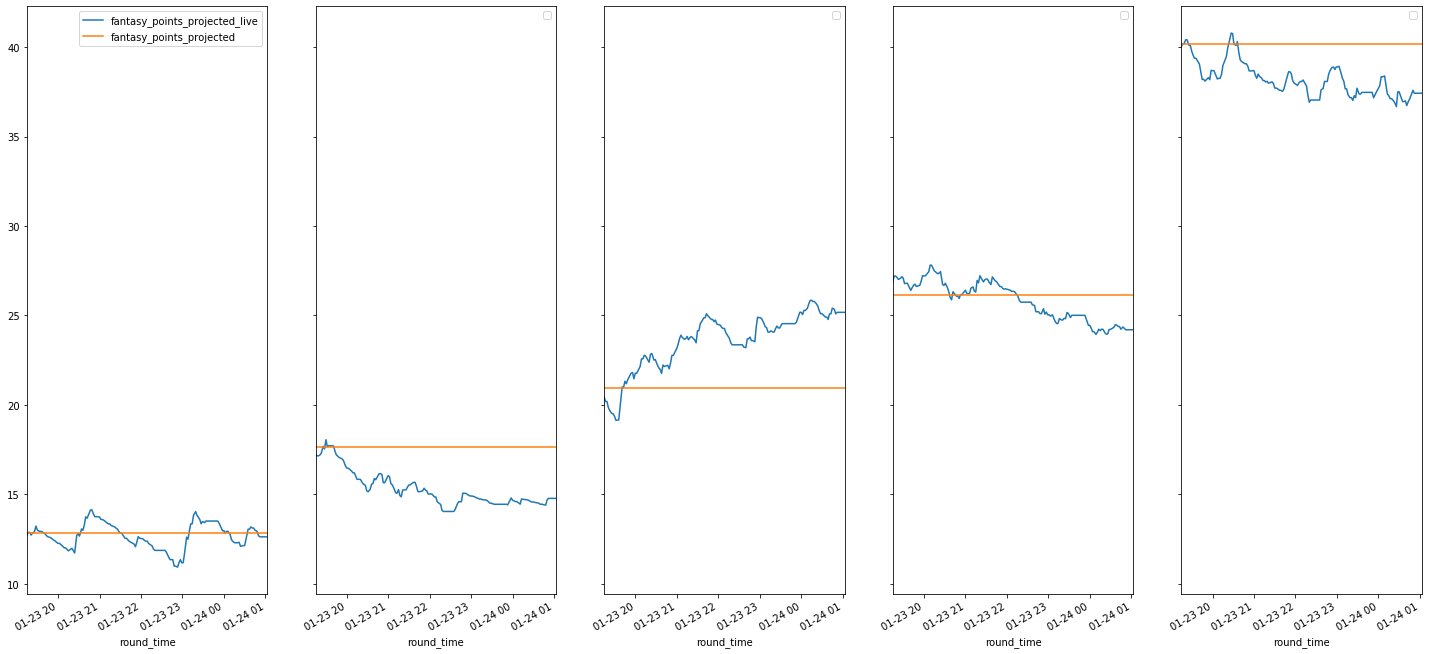

In [14]:
over_under(df)